In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
data.head()

,learnerID,assessmentItemID,answerCode,theta,difficultyLevel,discriminationLevel,guessLevel,knowledgeTag,gender,grade
0,A060000034,A060014001,1,0.574639,-1.479204,2.693081,3.400000e-09,7229,M,6
1,A060000034,A060014002,1,0.574639,-1.347461,4.063459,3.620000e-08,7229,M,6
2,A060000034,A060014003,1,0.574639,0.566275,1.834214,9.699000e-07,7229,M,6
3,A060000034,A060014004,1,0.574639,-0.361558,1.263308,8.770000e-08,7229,M,6
4,A060000034,A060014005,0,0.574639,0.955883,2.052489,1.700000e-08,7229,M,6


### **DATA**
[시간 순 정렬된 데이터]
- learnerID : 학생 ID
- assessmentItemID : 문제 ID
- answerCode : 채점결과 (0:틀림, 1:맞음)
- theta : testID 에 대한 응시자의 능력 수준 (-5~5)
- difficultyLevel : 문제 난이도 (-5~5)
- discriminationLevel : 변별도 (0~∞)
- guessLevel : 추측도 (0~1)
- knowledgeTag : 지식체계번호
- gender : 성별 (M/F)
- grade : 학년 (1~9)

In [8]:
# 데이터 전처리

data['learnerID'] = data['learnerID'].str[-9:]
data['assessmentItemID'] = data['assessmentItemID'].str[-9:]
data['learnerID'] = data['learnerID'].astype(int)
data['assessmentItemID'] = data['assessmentItemID'].astype(int)
data = data.drop(columns=['theta'])
data.replace({'gender':{'F' : 1, 'M' : 0}}, inplace = True) # gender열 원핫인코딩

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526700 entries, 0 to 2526699
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   learnerID            int64  
 1   assessmentItemID     int64  
 2   answerCode           int64  
 3   difficultyLevel      float64
 4   discriminationLevel  float64
 5   guessLevel           float64
 6   knowledgeTag         int64  
 7   gender               int64  
 8   grade                int64  
dtypes: float64(3), int64(6)
memory usage: 173.5 MB


In [29]:
data2 = data[data.groupby('learnerID')['learnerID'].transform('count') >= 100]
data2 = data2.reset_index(drop=True)

In [30]:
data2

,learnerID,assessmentItemID,answerCode,difficultyLevel,discriminationLevel,guessLevel,knowledgeTag,gender,grade
0,60000034,60014001,1,-1.479204,2.693081,3.400000e-09,7229,0,6
1,60000034,60014002,1,-1.347461,4.063459,3.620000e-08,7229,0,6
2,60000034,60014003,1,0.566275,1.834214,9.699000e-07,7229,0,6
3,60000034,60014004,1,-0.361558,1.263308,8.770000e-08,7229,0,6
4,60000034,60014005,0,0.955883,2.052489,1.700000e-08,7229,0,6
...,...,...,...,...,...,...,...,...,...
2053134,70001058,70152004,0,-0.639330,1.965869,2.915902e-52,7866,0,7
2053135,70001058,70152005,1,0.127438,3.632962,2.999959e-01,3288,0,7
2053136,70001058,70152006,0,0.472382,2.424987,4.472080e-05,9078,0,7
2053137,70001058,70152007,0,-0.033436,2.266465,5.300000e-09,9080,0,7


In [31]:
target = 'answerCode'

train, test = train_test_split(data2, train_size=0.80, test_size=0.20, shuffle=False)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, shuffle=False)

# 시간 순서 정렬 후, 최근 데이터 20% test 셋 생성, 남은 데이터의 최근 20% val 셋 생성

In [32]:
features = train.drop(columns=[target]).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [33]:
# 기준모델 mode
major = y_train.mode()[0]
y_pred=[major]*len(y_train)

from sklearn.metrics import accuracy_score
print('검증 정확도: ', accuracy_score(y_train, y_pred))

#기준모델의 검증 정확도 67%

검증 정확도:  0.6711595363194136


In [34]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

pipe2 = make_pipeline(XGBClassifier(n_jobs=-1,
                                    learning_rate=0.2))
pipe2.fit(X_train, y_train)

y_pred2 = pipe2.predict(X_val)
print('xgboost 검증 정확도: ', accuracy_score(y_val, y_pred2))

## 72%

xgboost 검증 정확도:  0.7244317403494032


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# XGBClassifier 객체 생성
xgb = XGBClassifier()

# 탐색할 하이퍼파라미터 공간 정의
param_dist = {
    'n_estimators': randint(50, 200),  # 트리의 개수
    'learning_rate': uniform(0.01, 0.3),  # 학습률
    'max_depth': randint(3, 10),  # 트리의 최대 깊이
    'min_child_weight': randint(1, 10),  # 자식 노드에 필요한 최소 가중치 합
    'subsample': uniform(0.6, 0.4),  # 각 트리를 학습하는데 사용할 훈련 데이터의 비율
    'colsample_bytree': uniform(0.6, 0.4),  # 각 트리를 학습하는데 사용할 특성의 비율
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, random_state=42
)

# 탐색 실행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters: ", random_search.best_params_)

# 최적의 모델로 예측 수행
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

# 검증 정확도 출력
from sklearn.metrics import accuracy_score
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# RandomizedSearchCV를 사용해 최적의 하이퍼파라미터를 탐색.
# 최적의 모델로 예측 수행 후 정확도 출력.

Best Hyperparameters:  {'colsample_bytree': 0.941203782186944, 'learning_rate': 0.0983346676208757, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 116, 'subsample': 0.6677970986744369}
Validation Accuracy: 0.7246204753076837


In [38]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

pipe2 = make_pipeline(XGBClassifier(n_jobs=-1,
                                    learning_rate=0.1, max_depth= 7, min_child_weight= 3, n_estimators= 115
                                    ))
pipe2.fit(X_train, y_train)

y_pred2 = pipe2.predict(X_val)
print('xgboost 검증 정확도: ', accuracy_score(y_val, y_pred2))

xgboost 검증 정확도:  0.724836607276037


In [39]:
pip install lightgbm

In [40]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# 파이프라인 생성
pipe_lgbm = make_pipeline(LGBMClassifier(n_jobs=-1, learning_rate=0.2))

# 모델 훈련
pipe_lgbm.fit(X_train, y_train)

# 검증 데이터 예측
y_pred_lgbm = pipe_lgbm.predict(X_val)

# 정확도 출력
print('LightGBM 검증 정확도:', accuracy_score(y_val, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 881909, number of negative: 432099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1314008, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.671160 -> initscore=0.713434
[LightGBM] [Info] Start training from score 0.713434
LightGBM 검증 정확도: 0.7252506065393619


In [41]:
# 파이프라인 생성
pipe_lgbm = make_pipeline(LGBMClassifier(n_jobs=-1,
                                         learning_rate=0.1, max_depth= 7, min_child_weight= 3, n_estimators= 115))

# 모델 훈련
pipe_lgbm.fit(X_train, y_train)

# 검증 데이터 예측
y_pred_lgbm = pipe_lgbm.predict(X_val)

# 정확도 출력
print('LightGBM 검증 정확도:', accuracy_score(y_val, y_pred_lgbm))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 881909, number of negative: 432099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1314008, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.671160 -> initscore=0.713434
[LightGBM] [Info] Start training from score 0.713434
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LightGBM 검증 정확도: 0.7257650615062876


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [160, 200, 2400],
    'max_depth': [7,9,11]
}

lgbm = LGBMClassifier()
grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적의 교차 검증 점수:", grid_search.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 712960, number of negative: 365098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1078058, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.661337 -> initscore=0.669260
[LightGBM] [Info] Start training from score 0.669260
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

In [ ]:
from sklearn.ensemble import RandomForestClassifier


pipe = make_pipeline(
    RandomForestClassifier(n_jobs=-1, random_state=28, oob_score=True)
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
print('Random Forest 검증 정확도: ', accuracy_score(y_val, y_pred))

## 65%%

Random Forest 검증 정확도:  0.6570699924803103


916

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# XGBoost 분류기 생성
xgb_clf = XGBClassifier()

# 탐색할 하이퍼파라미터 공간 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7,8,9],
    'learning_rate': [0.1, 0.15, 0.2],
    'subsample': [0.9, 1, 1.1],
    'colsample_bytree': [0.7,0.8,0.9]
}

# 랜덤 탐색을 사용하여 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# 데이터에 모델 적합
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", li

최적의 하이퍼파라미터: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.15, 'colsample_bytree': 0.7}


In [ ]:
xgb_clf_best = XGBClassifier(n_estimators=100, max_depth= 7, learning_rate=0.15, subsample=0.9, colsample_bytree=0.7)

# 학습 데이터에 모델 적합
xgb_clf_best.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = xgb_clf_best.predict(X_val)


print('xgboost 검증 정확도: ', accuracy_score(y_val, y_pred))


xgboost 검증 정확도:  0.7215463846123402


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
from sklearn.ensemble import RandomForestClassifier


pipe3 = make_pipeline(
    RandomForestClassifier(n_jobs=-1, random_state=54, oob_score=True, max_depth=20, min_samples_leaf=2,min_samples_split =4, n_estimators=52, max_features=0.7273335939652188)
)

pipe3.fit(X_train, y_train)

y_pred3 = pipe3.predict(X_val)
print('Random Forest 검증 정확도: ', accuracy_score(y_val, y_pred3))

Random Forest 검증 정확도:  0.9231260141686786


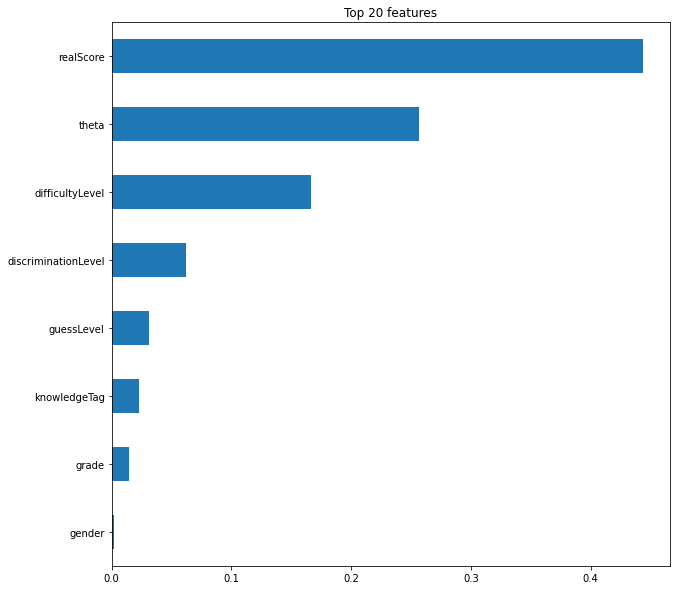

In [ ]:
# 특성 중요도
rf = pipe3.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
importances.sort_values()[-n:].plot.barh();

In [ ]:
X_train2 = X_train.drop('gender',axis=1)
X_val2 = X_val.drop('gender',axis=1)

In [ ]:
pipe4 = make_pipeline(
    RandomForestClassifier(n_jobs=-1, random_state=54, oob_score=True, max_depth=20, min_samples_leaf=2,min_samples_split =4, n_estimators=52, max_features=0.7273335939652188)
)

pipe4.fit(X_train2, y_train)

y_pred4 = pipe4.predict(X_val2)

print('Random Forest 검증 정확도: ', accuracy_score(y_val, y_pred4))

Random Forest 검증 정확도:  0.9245730597221673


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.1 MB/s 


In [ ]:
pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 117 kB/s 
     |████████████████████████████████| 13.1 MB 40.2 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=794c17f764ae94d2af8c4fc8a3ab9ad3dc44e641d3d6e11b0f857377c12561ca
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5

In [ ]:
import xgboost
import shap
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff78403d90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff783e45d0>})

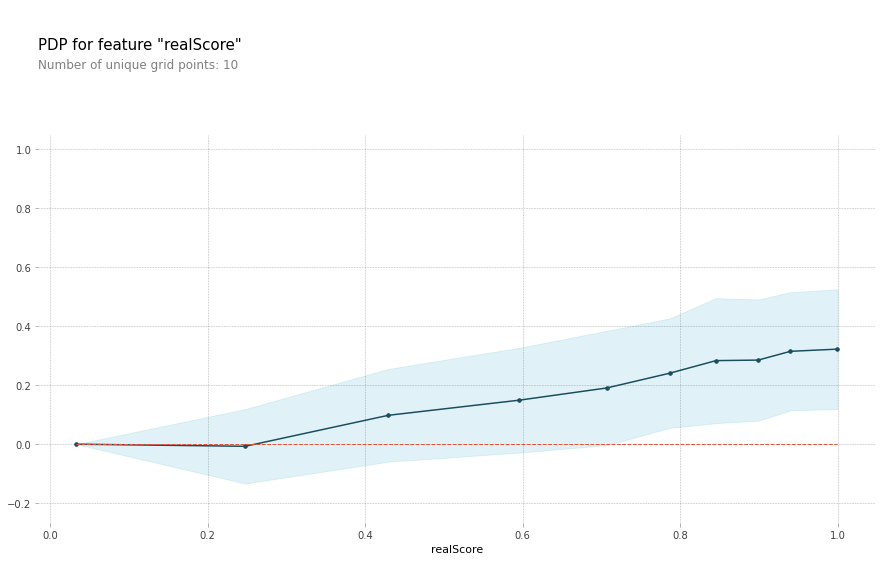

In [ ]:
feature = 'realScore'

isolated = pdp_isolate(model=pipe3,
                       dataset=X_train,
                       model_features= X_val.columns,
                       feature = feature)
pdp_plot(isolated, feature_name = feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff7832b150>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff78370b50>})

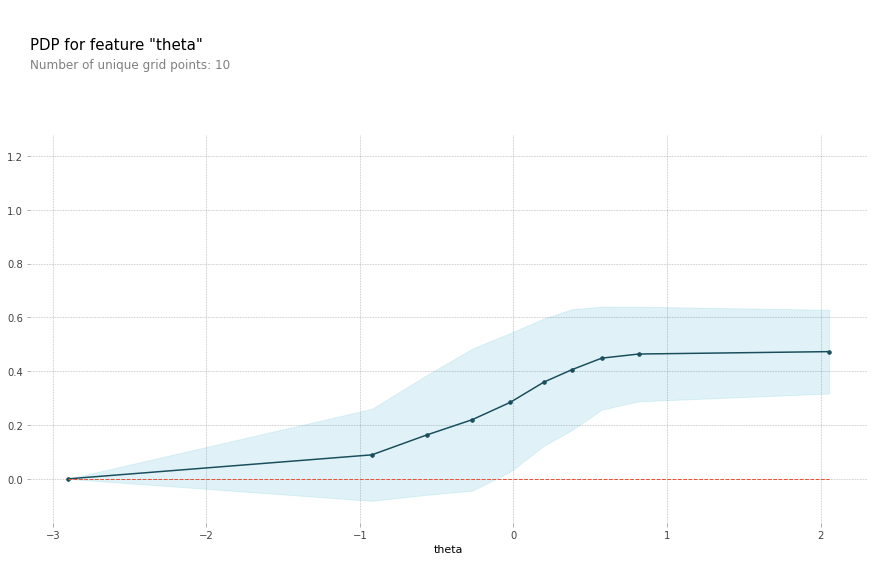

In [ ]:
feature = 'theta'

isolated2 = pdp_isolate(model=pipe3,
                       dataset=X_train,
                       model_features= X_val.columns,
                       feature = feature)
pdp_plot(isolated2, feature_name = feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff782fcad0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff7834e9d0>})

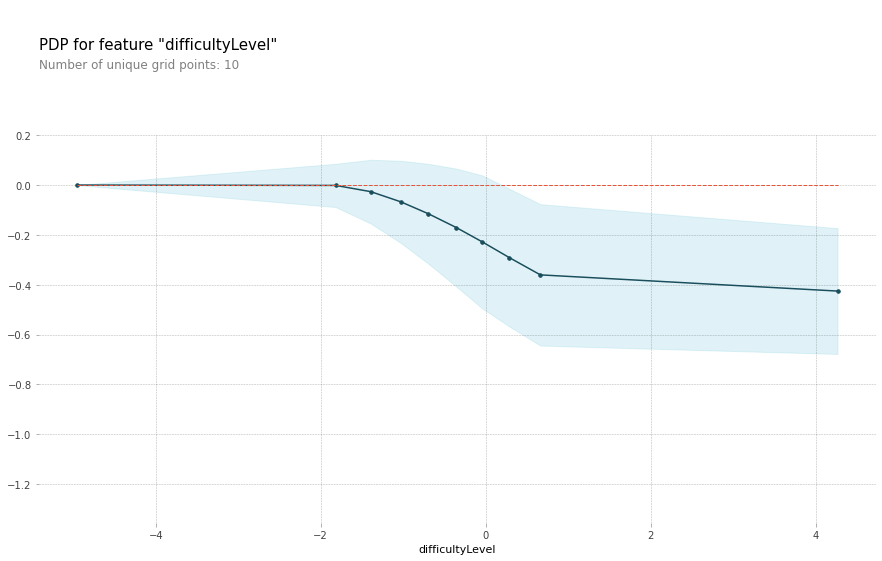

In [ ]:
feature = 'difficultyLevel'

isolated3 = pdp_isolate(model=pipe3,
                       dataset=X_train,
                       model_features= X_val.columns,
                       feature = feature)
pdp_plot(isolated3, feature_name = feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff782790d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7eff782767d0>})

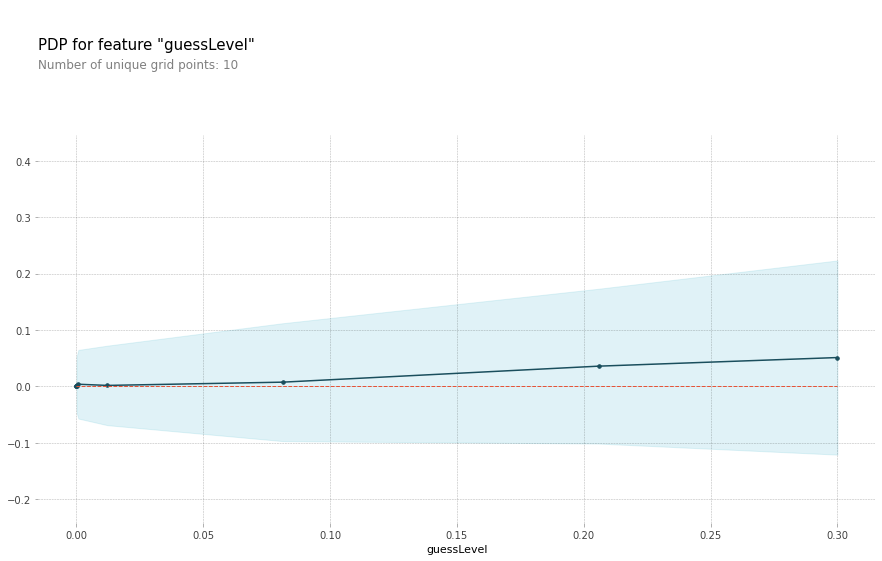

In [ ]:
feature = 'guessLevel'

isolated4 = pdp_isolate(model=pipe3,
                       dataset=X_train,
                       model_features= X_val.columns,
                       feature = feature)
pdp_plot(isolated4, feature_name = feature)

In [ ]:
import shap